In [1]:
cols = ['crim', 'zn', 'indus', \
        'chas', 'nox', 'rm', \
        'age', 'dis', 'rad', \
        'tax' ,'ptratio', 'black', \
       'lstat', 'medv']

In [2]:
#import smth

import os
import json
import boto3
import sklearn
import socket
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import numpy as np

from pyspark.sql import  SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator


print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return "{}proxy/{}/jobs/".format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

# small fix to enable UI views
SparkContext.uiWebUrl = property(uiWebUrl)

# spark configurtion in local regime 
conf = SparkConf().set('spark.master', 'local[*]').set('spark.driver.memory', '8g')

#some needed objects
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st057275/


In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

schema = StructType([StructField(col_name, FloatType(), True) for col_name in cols])


data = spark.read.option("delimiter", "  ").csv("./housing.csv", schema=schema)

data.printSchema()

root
 |-- crim: float (nullable = true)
 |-- zn: float (nullable = true)
 |-- indus: float (nullable = true)
 |-- chas: float (nullable = true)
 |-- nox: float (nullable = true)
 |-- rm: float (nullable = true)
 |-- age: float (nullable = true)
 |-- dis: float (nullable = true)
 |-- rad: float (nullable = true)
 |-- tax: float (nullable = true)
 |-- ptratio: float (nullable = true)
 |-- black: float (nullable = true)
 |-- lstat: float (nullable = true)
 |-- medv: float (nullable = true)



# Analysis of dataset

In [4]:
data.count() , len(data.columns)

(506, 14)

In [5]:
data.select('medv', 'chas', 'rm', 'age', 'rad', 'black').describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+------------------+
|summary|              medv|               chas|                rm|               age|               rad|             black|
+-------+------------------+-------------------+------------------+------------------+------------------+------------------+
|  count|                24|                506|               463|               501|               506|               506|
|   mean|12.512500007947287|0.06998221346512143| 6.413174948990989| 60.50667007573826|  59.8399209486166|13.807154139393402|
| stddev|  3.12650842868739|0.25442920332191404|1.7223350794288728|31.945046689100764|164.16099338666518|12.039852735065013|
|    min|               7.5|                0.0|             3.561|             1.137|               1.0|              0.32|
|    max|              19.0|                1.0|              40.5|              99.3|             666.0|             97.95|


In [6]:
import pyspark.sql.functions as f
data_agg = data.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in data.columns])
data_agg.show()

+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|black|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+
|   1|  0|    0|   0|  0| 43|  5|  0|  0| 42|    433|    0|   42| 482|
+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+



In [7]:
data.crosstab('ptratio', 'medv').sort("ptratio_medv").show(20)

+------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+----+
|ptratio_medv|10.2|10.9|11.0|11.7|11.8|12.7|13.1|13.4|13.5|14.1|14.5|14.9|15.6|16.1|18.6|19.0|7.5|8.3|8.4|9.5|9.6|null|
+------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+----+
|       12.13|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|  0|  0|  0|  0|  0|   1|
|       13.04|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|  0|  0|  0|  0|  0|   1|
|       13.28|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|  0|  0|  0|  0|  0|   1|
|       13.33|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|  0|  0|  0|  0|  0|   1|
|        14.7|   0|   0|   0|   0|   0|   0|   1|   0|   0|   0|   0|   0|   1|   0|   0|   0|  0|  0|  0|  0|  0|   0|
|       15.02|   0|   0|   0|   0|   0| 

 # Due to the fact that there are missing values in 'ptratio' , we have to drop all columns with 'ptratio 'null values, because most of them also coincide with null values in target variable.

In [8]:
from pyspark.sql.functions import col
data2 = data.where(col("ptratio").isNotNull())
data2.show()

+-------+----+-----+-----+-----+-----+------+------+-----+-----+-------+-----+-----+----+
|   crim|  zn|indus| chas|  nox|   rm|   age|   dis|  rad|  tax|ptratio|black|lstat|medv|
+-------+----+-----+-----+-----+-----+------+------+-----+-----+-------+-----+-----+----+
|0.21124|12.5| 7.87|  0.0|0.524| null|6.0821|   5.0|311.0| null|  29.93| 16.5| null|null|
|0.98843| 0.0| 8.14|  0.0|0.538| null|4.0952|   4.0|307.0| null|  19.88| 14.5| null|null|
|1.35472| 0.0| 8.14|  0.0|0.538| null| 4.175|   4.0|307.0| null|  13.04| 14.5| null|null|
|   null|1.32|  0.0|0.411|6.816| 40.5|8.3248|   5.0|256.0| null|   3.95| 31.6| null|null|
|0.22876| 0.0| 8.56|  0.0| 0.52|6.405|  85.4|2.7147|  5.0|384.0|   20.9| 70.8|10.63|18.6|
|1.62864| 0.0|21.89|  0.0|0.624| null|1.4394|   4.0|437.0| null|  34.41| 14.4| null|null|
|3.32105| 0.0|19.58|  1.0|0.871| null|1.3216|   5.0|403.0| null|  26.82| 13.4| null|null|
| 4.0974| 0.0|19.58|  0.0|0.871| null|1.4118|   5.0|403.0| null|  26.42| 15.6| null|null|
|2.37934| 

In [9]:
print((data2.count(), len(data2.columns)))

(73, 14)


In [24]:
import pyspark.sql.functions as f
data_agg = data2.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in data2.columns])
data_agg.show()

+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|black|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+
|   1|  0|    0|   0|  0| 43|  5|  0|  0| 42|      0|    0|   42|  49|
+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+



<AxesSubplot:>

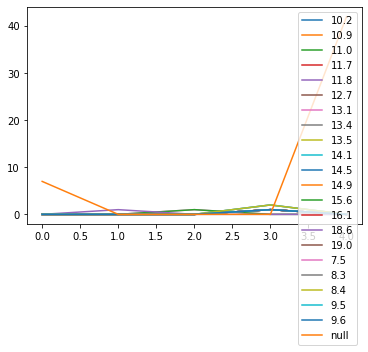

In [12]:
data2.crosstab('tax', 'medv').sort("tax_medv").toPandas().plot()

<AxesSubplot:>

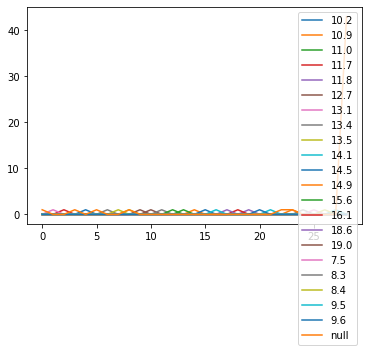

In [13]:
data2.crosstab('rm', 'medv').sort("rm_medv").toPandas().plot()

<AxesSubplot:>

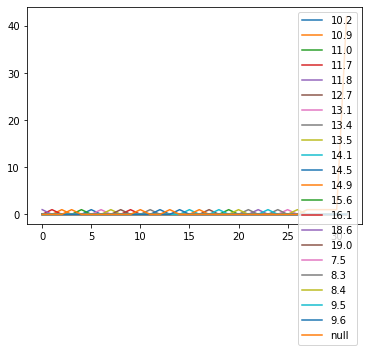

In [15]:
data2.crosstab('lstat', 'medv').sort("lstat_medv").toPandas().plot()

 # We should also drop 'lstat' column

In [16]:
from pyspark.sql.functions import col
data2 = data2.where(col("lstat").isNotNull())
data2.show()

+-------+---+-----+----+-----+-----+------+------+-----+-----+-------+-----+-----+----+
|   crim| zn|indus|chas|  nox|   rm|   age|   dis|  rad|  tax|ptratio|black|lstat|medv|
+-------+---+-----+----+-----+-----+------+------+-----+-----+-------+-----+-----+----+
|0.22876|0.0| 8.56| 0.0| 0.52|6.405|  85.4|2.7147|  5.0|384.0|   20.9| 70.8|10.63|18.6|
|3.53501|0.0|19.58| 1.0|0.871|6.152|  82.6|1.7455|  5.0|403.0|   14.7|88.01|15.02|15.6|
|2.44668|0.0|19.58| 0.0|0.871|5.272|  94.0|1.7364|  5.0|403.0|   14.7|88.63|16.14|13.1|
|51.1358|0.0| 18.1| 0.0|0.597| null| 1.413|  24.0|666.0| 20.2|    2.6|10.11| 15.0|null|
|14.0507|0.0| 18.1| 0.0|0.597| null|1.5275|  24.0|666.0| 20.2|  35.05|21.22| 17.2|null|
| 18.811|0.0| 18.1| 0.0|0.597| null|1.5539|  24.0|666.0| 20.2|  28.79|34.37| 17.9|null|
|45.7461|0.0| 18.1| 0.0|0.693| null|1.6582|  24.0|666.0| 20.2|  88.27|36.98|  7.0|null|
|18.0846|0.0| 18.1| 0.0|0.679| null|1.8347|  24.0|666.0| 20.2|  27.25|29.05|  7.2|null|
|10.8342|0.0| 18.1| 0.0|0.679|6.

In [17]:
import pyspark.sql.functions as f
data_agg = data2.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in data2.columns])
data_agg.show()

+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|black|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+
|   0|  0|    0|   0|  0|  7|  0|  0|  0|  0|      0|    0|    0|   7|
+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+



In [18]:
data2.describe('rm').show()

+-------+------------------+
|summary|                rm|
+-------+------------------+
|  count|                24|
|   mean| 6.247416694959004|
| stddev|0.4061889127466313|
|    min|             5.272|
|    max|             6.833|
+-------+------------------+



In [19]:
data2.describe('medv').show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|                24|
|   mean|12.512500007947287|
| stddev|  3.12650842868739|
|    min|               7.5|
|    max|              19.0|
+-------+------------------+



In [20]:
data2 = data2.fillna(12.512500007947287, subset = 'medv')
data2 = data2.fillna (6.247416694959004, subset = 'rm')

In [21]:
import pyspark.sql.functions as f
data_agg = data2.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in data2.columns])
data_agg.show()

+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|black|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+
|   0|  0|    0|   0|  0|  0|  0|  0|  0|  0|      0|    0|    0|   0|
+----+---+-----+----+---+---+---+---+---+---+-------+-----+-----+----+



In [22]:
import six
for i in data2.columns:
    if not( isinstance(data2.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation medv to ", i, data2.stat.corr('medv',i))

Correlation medv to  crim -0.2030843765082188
Correlation medv to  zn nan
Correlation medv to  indus -0.36207892486931337
Correlation medv to  chas 0.2093166246336407
Correlation medv to  nox -0.1962814307107618
Correlation medv to  rm -0.010627601133553198
Correlation medv to  age -0.005534441961469719
Correlation medv to  dis 0.02138222549282407
Correlation medv to  rad -0.008244966525770751
Correlation medv to  tax -0.12006677786574514
Correlation medv to  ptratio -0.014504499686995617
Correlation medv to  black 0.1927328113789741
Correlation medv to  lstat -0.5031562937330367
Correlation medv to  medv 1.0


# We shoud drop column with comparatively small correlation to target variable 'medv'

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
featureCols = ["crim",   'indus', 'OHE', 'nox',   'black',  "lstat",  'tax']

OHE = OneHotEncoder(inputCols=['chas'],outputCols=['OHE'])
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# setup the pipeline
pipeline = Pipeline(stages= [OHE, assembler,standardScaler])
model = pipeline.fit(data2)
df = model.transform(data2)

# Train-test split

In [24]:
train_data, test_data = df.select("features_scaled", "medv").randomSplit([.8,.2],seed = 1234)

In [25]:
print((test_data.count(), len(test_data.columns)))

(7, 2)


In [26]:
print((train_data.count(), len(train_data.columns)))

(24, 2)


# Linear regression

In [27]:
lr = LinearRegression(featuresCol='features_scaled', labelCol="medv", predictionCol='predmedhv', 
                               maxIter=10,  regParam=0.3, elasticNetParam=0.8)

model2 = lr.fit(train_data)
predictions = model2.transform(test_data)

# view some of the columns generated
predictions.select('features_Scaled', 'medv', 'predmedhv').show()

+--------------------+-------+------------------+
|     features_Scaled|   medv|         predmedhv|
+--------------------+-------+------------------+
|[0.15377668695482...|   13.1|12.575774315598155|
|[0.29344138853173...|   12.7| 12.63015067655843|
|[0.88310284277061...|12.5125|13.031975744974908|
|[0.99683829892464...|    8.3|11.015084728158474|
|[1.13663816416328...|12.5125|14.886602318013859|
|[1.18229327230073...|12.5125|12.662676064999065|
|[2.36709417517895...|   10.9|12.342503492645246|
+--------------------+-------+------------------+



# Evaluation of  pipeline (5-fold RMSE)

In [28]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="predmedhv", \
                 labelCol="medv",metricName="rmse")
print(lr_evaluator.evaluate(predictions))

1.4957541919564634


In [29]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.2, 0.3])
             .build())

In [30]:
from time import *
start_time = time()

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=lr_evaluator, numFolds=5) # numFolds * size_grid = 10 

# Run cross validations
cvModel = cv.fit(train_data)
# likely take a fair amount of time
end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

Time to train model: 6.542 seconds


# tune hyperparameters 

In [31]:
bestModel = cvModel.bestModel
bestModel.extractParamMap()

{Param(parent='LinearRegression_f36b7cb712a3', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_f36b7cb712a3', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.8,
 Param(parent='LinearRegression_f36b7cb712a3', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_f36b7cb712a3', name='featuresCol', doc='features column name.'): 'features_scaled',
 Param(parent='LinearRegression_f36b7cb712a3', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_f36b7cb712a3', name='labelCol', doc='label column name.'): 'medv',
 Param(parent='LinearRegression_f36b7cb712a3', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 'square

In [32]:
hold_out_preds = bestModel.transform(test_data)

In [33]:
print(lr_evaluator.evaluate(hold_out_preds))
print(lr_evaluator.getMetricName())
regr_model = lr_evaluator.evaluate(hold_out_preds)

1.491737711703905
rmse


#  RandomForest

In [34]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features_scaled", labelCol = 'medv')
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
print(rf_evaluator.evaluate(rf_predictions))

1.4850507296891744


In [35]:
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 20])
               .addGrid(rf.maxBins, [5, 32,  50])
               .addGrid(rf.numTrees, [40,50 ])
             .build())

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rf_evaluator,
                      numFolds = 5)

In [36]:
rfcvModel = rfcv.fit(train_data)

In [37]:
bestModel2 = rfcvModel.bestModel
bestModel2.extractParamMap()

{Param(parent='RandomForestRegressor_ba6fd6aa69bb', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestRegressor_ba6fd6aa69bb', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestRegressor_ba6fd6aa69bb', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestRegressor_ba6fd6aa69bb', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supporte

In [38]:
hold_out_preds2 = bestModel2.transform(test_data)

In [39]:
print(rf_evaluator.evaluate(hold_out_preds2))
print(rf_evaluator.getMetricName())
rf_rmse = rf_evaluator.evaluate(hold_out_preds2)

1.4093152079582587
rmse


# gbt 

In [40]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features_scaled', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'medv', 'features_scaled').show(5)
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+-------+--------------------+
|        prediction|   medv|     features_scaled|
+------------------+-------+--------------------+
|15.750548646953066|   13.1|[0.15377668695482...|
|14.165359655210901|   12.7|[0.29344138853173...|
| 9.531428183695713|12.5125|[0.88310284277061...|
| 8.601816994117012|    8.3|[0.99683829892464...|
| 12.51583866312528|12.5125|[1.13663816416328...|
+------------------+-------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 1.72275


In [41]:
gbt_model.extractParamMap()

{Param(parent='GBTRegressor_16cebb1c8638', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTRegressor_16cebb1c8638', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTRegressor_16cebb1c8638', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regr

In [42]:
gbparamGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5,10, 20, 30])
             .addGrid(gbt.maxBins, [32, 40, 45])
             .addGrid(gbt.maxIter, [5,7])
             .build())

In [43]:
gbcv = CrossValidator(estimator = gbt,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = gbt_evaluator,
                      numFolds = 5)

In [44]:
gbcv_model = gbcv.fit(train_data)

In [45]:
bestModel3 = gbcv_model.bestModel
bestModel3.extractParamMap()

{Param(parent='GBTRegressor_16cebb1c8638', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTRegressor_16cebb1c8638', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTRegressor_16cebb1c8638', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regr

In [46]:
hold_out_preds3 = bestModel3.transform(test_data)

In [47]:
print(gbt_evaluator.evaluate(hold_out_preds3))
print(gbt_evaluator.getMetricName())
rmse = gbt_evaluator.evaluate(hold_out_preds3)

1.7459998255671352
rmse


# The best model is random forest with the smallest rmse


In [48]:
df2 = spark.createDataFrame(
    [
        ('linear regression', regr_model), 
        ( 'random forest',rf_rmse),
        ('gradient boosted tree', rmse)
    ],
    ["model", "rmse"]  
)


In [49]:
df2.show()

+--------------------+------------------+
|               model|              rmse|
+--------------------+------------------+
|   linear regression| 1.491737711703905|
|       random forest|1.4093152079582587|
|gradient boosted ...|1.7459998255671352|
+--------------------+------------------+

